In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [126]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

Mounted at /content/drive


In [56]:
dir = os.path.join(path, 'features_ring')
df = pd.DataFrame()
for file in os.listdir(dir):
    if file.endswith('.tsv'):
        df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
        df = pd.concat([df, df_temp])

print("Done!")

Done!


## Optional: Run this cell if you want to remove double instance in .tsv files

Example:

`1lu4	A	1091	 	I	H	0.03	20	11	-1.253	-0.67	H	-1.239	-0.547	2.131	0.393	0.816	A	1094	 	R	H	0.448	15	6	-1.088	-0.594	H	1.538	-0.055	1.502	0.44	2.897	HBOND`

`1lu4	A	1091	 	I	H	0.03	20	11	-1.253	-0.67	H	-1.239	-0.547	2.131	0.393	0.816	A	1094	 	R	H	0.448	15	6	-1.088	-0.594	H	1.538	-0.055	1.502	0.44	2.897	VDW`



In [58]:
columns_to_check = df.columns[:-1]
df_copy = df.copy()
df = df.drop_duplicates(subset=columns_to_check, keep='last')


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [130]:
df['Interaction'] = df['Interaction'].fillna('Unclassified')  # Replace None value on column 'Interaction' with a proper label
interaction_counts = df['Interaction'].value_counts() # Count each class
print(interaction_counts)

Interaction
HBOND           901814
Unclassified    860202
VDW             640469
PIPISTACK        32965
IONIC            30355
PICATION          7623
PIHBOND           1836
SSBOND            1792
Name: count, dtype: int64


In [131]:
le = LabelEncoder()

In [136]:
df = df[df.Interaction.notna()]
contact_dict = {"HBOND": 0, "Unclassified": 1, "VDW": 2, "PIPISTACK": 3, "IONIC": 4, "PICATION": 5, "PIHBOND": 6, "SSBOND": 7,  }
y = df['Interaction']
cat_names = list(y.astype('category').cat.categories)
y.replace(contact_dict, inplace=True)

#X = df[['s_ss8','s_rsa', 's_up', 's_down', 's_phi', 's_a5', 't_ss8','t_rsa', 't_up', 't_down']] Select the features in order to perform features selection

X = df[['s_ss8','s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 't_ss8','t_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']].copy()

In [137]:
# Enconde 's_ss8' into a numerical form (S_SS8 it's char)
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X = X.drop(columns=['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['t_ss8'])
# Fill None value with mean of the column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

In [141]:
# Scale the features
minMax = MinMaxScaler()
X_scaled = minMax.fit_transform(X)
input_dim = X_scaled.shape[1]
# Store the cardinality of each class to weight its contribution to the model
num_classes = len(contact_dict)
print("Input dimension:", input_dim)  # 22

Input dimension: 22


In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [143]:
class_distribution = Counter(y_train)
print("Original class distribution:", class_distribution)

sampling_strategy = {
    0: 813245,  # HBOND
    1: 860202,  # None
    2: 640469,  # VDW
    3: 300000,  # PIPISTACK
    4: 300000,  # IONIC
    5: 10000,  # PICATION
    6: 10000,  # PIHBOND
    7: 10000   # SSBOND
}

Original class distribution: Counter({0: 721451, 1: 688161, 2: 512375, 3: 26372, 4: 24284, 5: 6098, 6: 1469, 7: 1434})


In [ ]:
oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)


In [ ]:
# Fit and resample the training data
X_bal, y_bal = oversample.fit_resample(X_train, y_train)

# Convert labels to categorical format
y_cat = to_categorical(y_bal, num_classes)

# Verify the resampled data
print('Original y_train distribution:', Counter(y_train))
print('Resampled y_bal distribution:', Counter(y_bal))

In [ ]:
# Store oversampled features and label
np.save('X_bal.npy', X_bal)
np.save('y_bal.npy', y_bal)

## 2 - LOAD Existing data


In [144]:
X_bal = np.load(path + '/X_bal-SMOTE22.npy')
y_bal = np.load(path + '/y_bal-SMOTE22.npy')

In [145]:
print('Original y_train distribution:', Counter(y_train))
print('Resampled y_bal distribution:', Counter(y_bal))

Original y_train distribution: Counter({0: 721451, 1: 688161, 2: 512375, 3: 26372, 4: 24284, 5: 6098, 6: 1469, 7: 1434})
Resampled y_bal distribution: Counter({1: 860202, 0: 813245, 2: 640469, 4: 300000, 3: 300000, 5: 10000, 6: 10000, 7: 10000})


In [146]:
# Count the class in X_bal
unique_values, counts = np.unique(y_bal, return_counts=True)
print(dict(zip(unique_values, counts)))

{0: 813245, 1: 860202, 2: 640469, 3: 300000, 4: 300000, 5: 10000, 6: 10000, 7: 10000}


In [147]:
y_train_tensor = torch.tensor(y_bal, dtype=torch.long)
X_train_tensor = torch.tensor(X_bal, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# NN

Define the Neural Network model

In [150]:
# Define the neural network model
class SimpleNN(nn.Module):
    def __init__(self): #Fixed typo here
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)  # Input layer with n features, outputting to 64 neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 8)
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to first layer
        x = self.dropout(x)  # Apply dropout after first hidden layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to second layer
        x = self.dropout(x)  # Apply dropout after second hidden layer
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to third layer
        x = self.dropout(x)  # Apply dropout after third hidden layer
        x = torch.softmax(self.fc4(x), dim=1)  # Apply softmax activation to fourth layer
        # x = self.fc4(x)              # Output layer (no activation function for multi-class classification)
        return x

In [151]:
train_dataset_maj = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_maj = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset_maj, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset_maj, batch_size=512, shuffle=False)

In [152]:
# Create an instance of the model
model2 = SimpleNN()

# Move model to GPU if available
model2 = model2.to(device)

# Define loss function and optimizer
# Create the criterion with class weights
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.002)

## Train Loop

In [153]:
from sklearn.metrics import matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score

# Initialize lists to store metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
mcc_scores = []
balanced_acc_scores = []
avg_precision_scores = []
auc_roc_scores = []

# Training loop
epochs = 2

for epoch in range(epochs):
    model2.train()  # Set the model to training mode

    # Variables to accumulate loss and accuracy
    epoch_train_loss = 0
    epoch_correct_train = 0
    total_train_samples = 0

    # Use a dataloader to iterate over the training data in batches
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU

        optimizer.zero_grad()  # Clear gradients from the previous iteration

        # Forward pass and compute train loss
        outputs = model2(inputs)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        # Compute train accuracy (for this batch)
        _, predicted_train = torch.max(outputs, 1)
        epoch_correct_train += (predicted_train == labels).sum().item()
        epoch_train_loss += train_loss.item() * len(labels)
        total_train_samples += len(labels)

        # Print training progress (optional)
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(train_loader)}], '
                  f'Train Loss: {train_loss.item():.4f}, Train Acc: {epoch_correct_train / total_train_samples:.4f}')

    # Average training loss and accuracy
    avg_train_loss = epoch_train_loss / total_train_samples
    train_accuracy = epoch_correct_train / total_train_samples

    # Evaluate on test set (after each epoch)
    model2.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0
        correct_test = 0
        total_test_samples = 0

        # Variables to store all true labels and predicted probabilities for metrics
        all_labels = []
        all_preds = []
        all_probs = []

        # Use the test dataloader to iterate over the test data
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs_test = model2(inputs)
            test_loss += criterion(outputs_test, labels).item() * len(labels)  # Sum up batch loss
            total_test_samples += len(labels)

            # Compute test accuracy
            _, predicted_test = torch.max(outputs_test, 1)
            correct_test += (predicted_test == labels).sum().item()

            # Collect all true labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted_test.cpu().numpy())
            all_probs.extend(torch.softmax(outputs_test, dim=1).cpu().numpy())

        # Calculate average test loss and accuracy
        avg_test_loss = test_loss / total_test_samples
        test_accuracy = correct_test / total_test_samples

        # Calculate metrics
        y_true = np.array(all_labels)  # Etichette vere
        y_pred = np.array(all_preds)  # Etichette predette
        y_scores = np.array(all_probs)

        mcc = matthews_corrcoef(y_true, y_pred)
        balanced_acc = balanced_accuracy_score(y_true, y_pred)
        avg_precision = average_precision_score(y_true, y_scores, average='weighted')
        auc_roc = roc_auc_score(y_true, y_scores, multi_class="ovr")

    # Print and store metrics (after each epoch)
    print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
          f'Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}, '
          f'MCC: {mcc:.4f}, Balanced Acc: {balanced_acc:.4f}, '
          f'Avg Precision: {avg_precision:.4f}, AUC-ROC: {auc_roc:.4f}')

Epoch [1/2], Batch [1/5750], Train Loss: 2.0786, Train Acc: 0.1094
Epoch [1/2], Batch [101/5750], Train Loss: 1.9299, Train Acc: 0.3176
Epoch [1/2], Batch [201/5750], Train Loss: 1.9314, Train Acc: 0.3333
Epoch [1/2], Batch [301/5750], Train Loss: 1.7622, Train Acc: 0.3666
Epoch [1/2], Batch [401/5750], Train Loss: 1.7817, Train Acc: 0.3963
Epoch [1/2], Batch [501/5750], Train Loss: 1.7641, Train Acc: 0.4163
Epoch [1/2], Batch [601/5750], Train Loss: 1.7536, Train Acc: 0.4310
Epoch [1/2], Batch [701/5750], Train Loss: 1.7854, Train Acc: 0.4416
Epoch [1/2], Batch [801/5750], Train Loss: 1.7556, Train Acc: 0.4504
Epoch [1/2], Batch [901/5750], Train Loss: 1.7809, Train Acc: 0.4572
Epoch [1/2], Batch [1001/5750], Train Loss: 1.7587, Train Acc: 0.4633
Epoch [1/2], Batch [1101/5750], Train Loss: 1.7573, Train Acc: 0.4684
Epoch [1/2], Batch [1201/5750], Train Loss: 1.7536, Train Acc: 0.4730
Epoch [1/2], Batch [1301/5750], Train Loss: 1.7373, Train Acc: 0.4768
Epoch [1/2], Batch [1401/5750], 

In [154]:
y_test_num = y_test.astype(int)
y_pred = y_pred.astype(int)
cm = confusion_matrix(y_test_num, y_pred)
labels = sorted(y.unique())

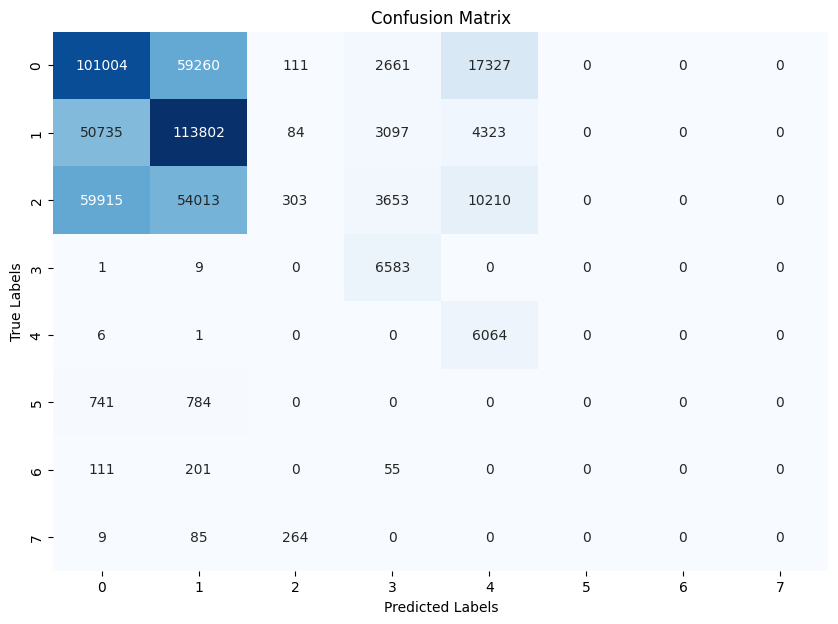

In [155]:
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

#plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# XGBoost

In [156]:
# Convert categorical features to numerical values
def convert_categories_to_numerical(df):
    for column in df.columns:
        if df[column].dtype.name == 'category':
            df[column] = df[column].cat.codes
    return df

In [157]:
params = {
    'device': 'cuda',
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y)),
    'eval_metric': 'mlogloss',
    'max_depth': 10,
    'learning_rate': 0.2,
}

In [159]:
X_train, X_val, y_train, y_val = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

In [160]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test_tensor, label=y_test_tensor)
dval = xgb.DMatrix(X_val, label=y_val)

In [166]:
model1 = xgb.train(params, dtrain, num_boost_round=2500, evals =  [(dval, 'mlogloss')], early_stopping_rounds=20)

[0]	mlogloss-mlogloss:1.80378
[1]	mlogloss-mlogloss:1.63313
[2]	mlogloss-mlogloss:1.50995
[3]	mlogloss-mlogloss:1.41516
[4]	mlogloss-mlogloss:1.33858
[5]	mlogloss-mlogloss:1.27746
[6]	mlogloss-mlogloss:1.22746
[7]	mlogloss-mlogloss:1.18548
[8]	mlogloss-mlogloss:1.15049
[9]	mlogloss-mlogloss:1.12060
[10]	mlogloss-mlogloss:1.09481
[11]	mlogloss-mlogloss:1.07219
[12]	mlogloss-mlogloss:1.05249
[13]	mlogloss-mlogloss:1.03496
[14]	mlogloss-mlogloss:1.01847
[15]	mlogloss-mlogloss:1.00381
[16]	mlogloss-mlogloss:0.99123
[17]	mlogloss-mlogloss:0.97976
[18]	mlogloss-mlogloss:0.97010
[19]	mlogloss-mlogloss:0.96033
[20]	mlogloss-mlogloss:0.95251
[21]	mlogloss-mlogloss:0.94525
[22]	mlogloss-mlogloss:0.93869
[23]	mlogloss-mlogloss:0.93227
[24]	mlogloss-mlogloss:0.92711
[25]	mlogloss-mlogloss:0.92177
[26]	mlogloss-mlogloss:0.91704
[27]	mlogloss-mlogloss:0.91181
[28]	mlogloss-mlogloss:0.90765
[29]	mlogloss-mlogloss:0.90411
[30]	mlogloss-mlogloss:0.89949
[31]	mlogloss-mlogloss:0.89580
[32]	mlogloss-mlog

### Save the model .json for use it in the predictor software

In [82]:
## Save model
model1.save_model(path+'/xgboost_model.json')

## Metrics

In [168]:
y_pred_prob = model1.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

In [170]:
# np array to df y_pred_prob
dfprob = pd.DataFrame(y_pred_prob)
dfprob.head()

,0,1,2,3,4,5,6,7
0,0.004358,0.799992,0.195613,1.581666e-08,3.832067e-08,2.174162e-08,3.669176e-05,8.898479e-08
1,0.149146,0.078987,0.326598,4.447387e-01,1.956897e-07,1.392254e-04,3.906328e-04,1.884870e-07
2,0.293399,0.485928,0.219913,3.529807e-09,6.636817e-04,9.520543e-05,1.002876e-06,1.305673e-07
3,0.733405,0.061688,0.204907,2.425155e-09,3.062359e-08,1.330806e-08,1.995511e-08,6.594710e-08
4,0.234022,0.563031,0.199861,3.462747e-07,2.676081e-07,1.579971e-05,3.069053e-03,2.462558e-07


In [169]:
# Converti y_test in array numpy se non lo è già
y_test = np.array(y_test_tensor)

# Usa LabelEncoder per convertire le etichette da stringhe a numeri
label_encoder = LabelEncoder()
y_test_num = label_encoder.fit_transform(y_test_tensor)

# Ora y_test_num è numerico e puoi confrontarlo con y_pred
print(f'Etichette uniche in y_test_num: {np.unique(y_test_num)}')

Etichette uniche in y_test_num: [0 1 2 3 4 5 6 7]


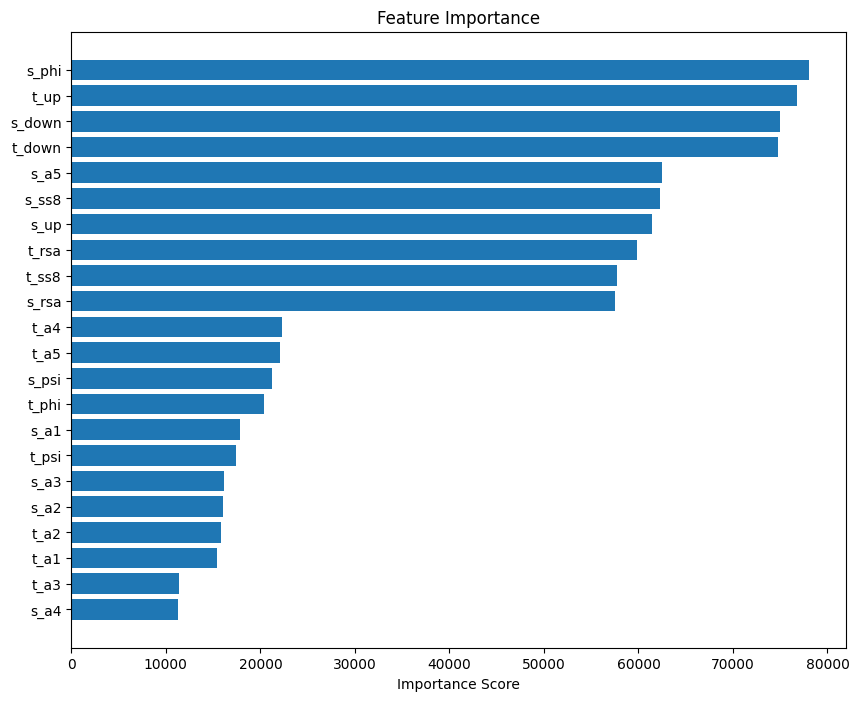

In [171]:
# Estrai le importanze delle feature
importance = model1.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'
feature_names = [
    's_ss8', 's_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2',
    's_a3', 's_a4', 's_a5', 't_ss8', 't_rsa', 't_up', 't_down', 't_phi',
    't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5'
]# Ordinare le feature per importanza
# Create a mapping from old keys to new feature names
key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

# Replace keys in the importance dictionary
mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

# Sort the features by importance
sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*sorted_importance)

# Visualizza l'importanza delle feature
plt.figure(figsize=(10, 8))
plt.barh(features, scores)
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
plt.show()

In [172]:
accuracy = accuracy_score(y_test_num, y_pred)
print(f'Accuracy: {accuracy:.4f}')
balanced_acc = balanced_accuracy_score(y_test_num, y_pred)
print(f'Balanced Accuracy: {balanced_acc:.4f}')
auc_roc = roc_auc_score(y_test_num, y_pred_prob, multi_class='ovr')
print(f'AUC-ROC: {auc_roc:.4f}')
mcc = matthews_corrcoef(y_test_num, y_pred)
print(f'Matthews Correlation Coefficient: {mcc:.4f}')
average_precision = average_precision_score(y_test_num, y_pred_prob, average='weighted')
print(f'Average Precision Score: {average_precision:.4f}')

Accuracy: 0.5622
Balanced Accuracy: 0.5201
AUC-ROC: 0.8967
Matthews Correlation Coefficient: 0.3566
Average Precision Score: 0.5793


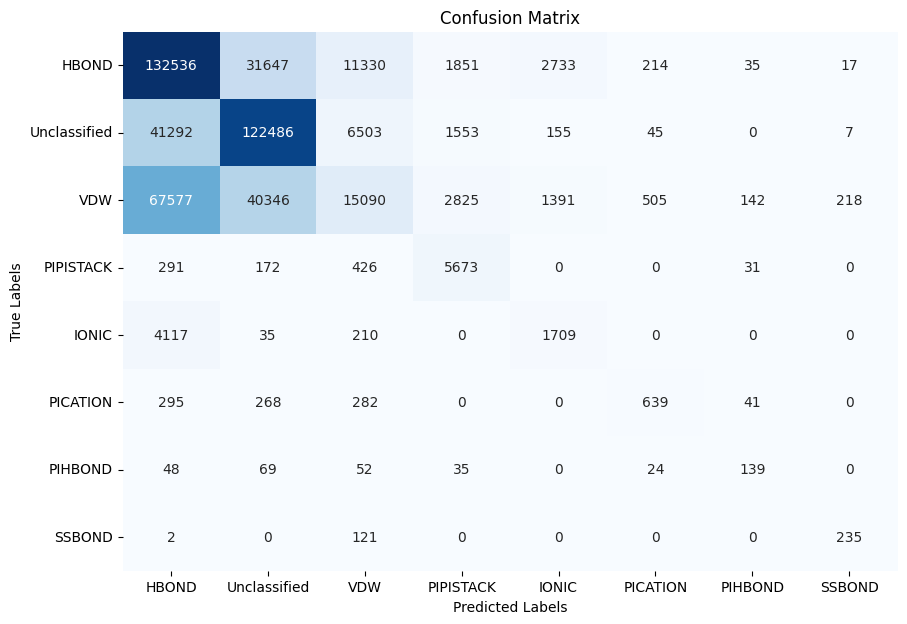

In [173]:
cm = confusion_matrix(y_test_num, y_pred)
labels = sorted(contact_dict.keys(), key=lambda x: contact_dict[x])  # Sort by dict values
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

#plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
